In [12]:
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sys, os
from collections import defaultdict

#sys.path.append('.')

from sklearn.cluster import KMeans

import geneinfo.information as gi

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# scale down size of default plots
sns.set_context("paper")
import matplotlib as mpl
scale = 0.8
d = dict([(k, v*scale) for (k, v) in sns.plotting_context('paper').items()])
d['figure.figsize'] = [5.4, 3.5]
mpl.rcParams.update(d)

# high-res plots
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

#from matplotlib_venn import venn2, venn3

class left:
    def __rlshift__(self, df):
        "Left align columns of data frame: df << left()"
        left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
        left_aligned_df = left_aligned_df.set_table_styles(
            [dict(selector = 'th', props=[('text-align', 'left')])])
        display(left_aligned_df)

from math import sqrt
from itertools import zip_longest

def list_genes(words, ncols=None):
    n = len(words)
    col_width = max(map(len, words)) + 1
    if ncols is None:
        ncols = max(100//col_width, 1+sqrt(n/col_width))
    nrows = int(n/ncols) + 1
    rows = []
    for r in range(0, n, nrows):
        rows.append(words[r:r+nrows])
    for row in list(zip_longest(*rows, fillvalue='')):
        line = []
        for gene in row:
            line.append(gene.ljust(col_width))
        print(''.join(line))
        

In [13]:
# %env http_proxy=http://proxy-default:3128
# %env https_proxy=http://proxy-default:3128

In [14]:
import expression_plots as ep
# import importlib
# importlib.reload(ep)
# ep.load_data("../data/xy_proj/preproc_8_starsolo_multimap_simpl_soupx.h5ad")

ep.load_data("../data/xy_proj/CELL_preproc_8_starsolo_multimap.h5ad")
# ep.adata.X = ep.adata.layers["soupX_counts"].copy()
# sc.pp.normalize_total(ep.adata)
# sc.pp.log1p(ep.adata)
# ep.adata.layers["norm_log"] = ep.adata.X.copy()

# .obs["SPECIES"] == "Human" for nuclei data and 
# .obs["SPECIES"] == "Human_cell" for cell data

#ep.adata = ep.adata[(ep.adata.obs.SPECIES == "Human")]
ep.adata = ep.adata[(ep.adata.obs.SPECIES == "Human_cell")]

In [15]:
ep.adata

View of AnnData object with n_obs × n_vars = 15712 × 14934
    obs: 'DATASET', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'doublet_scores', 'predicted_doublets', 'SPECIES', '_scvi_batch', '_scvi_labels', 'leiden', 'CB_exp', 'cluster', 'clst_groups', 'clst_groups_class', 'cell_class', 'clst_groups_sep', 'mean_spg_exp', 'mean_spt_exp_1', 'mean_spt_exp_2', 'Pseudotime_scaled', 'cell_diff', 'percent.X', 'percent.Y', 'percent.X_unspl', 'percent.Y_unspl', 'enrich_rate', 'enrich_rate_scaled'
    var: 'chromosome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'DATASET_colors', 'SPECIES_colors', '_scvi_manager_uuid', '_scvi_uuid', 'clst_groups_colors', 'cluster_colors', 'cluster_sizes', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'paga', 'rank_genes_groups', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'norm_sct', 'raw_counts', 'soupX_counts', 'spliced', 'unspl_norm', 'unspliced'


Distribution of cell counts across pseudo-time:

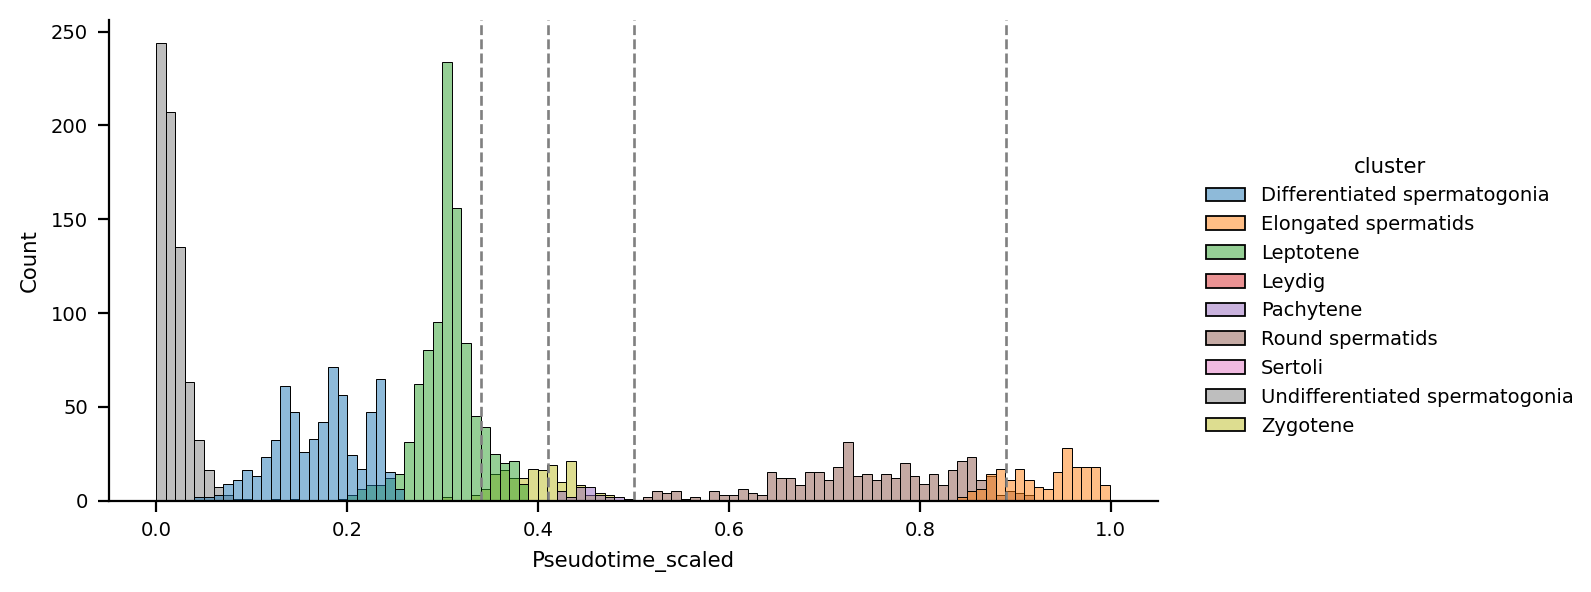

In [16]:
df = sc.get.obs_df(ep.adata, keys=['cluster', 'Pseudotime_scaled'])
sns.displot(df, x='Pseudotime_scaled', hue='cluster', bins=100, height=3, aspect=2) ;
lines = [0.34, 0.41, 0.5, 0.89]
[plt.axvline(x, color='grey', linestyle='dashed') for x in lines] ;

In [17]:
from geneinfo.utils import GeneListCollection
sheet = GeneListCollection(google_sheet='1JSjSLuto3jqdEnnG7JqzeC_1pUZw76n7XueVAYrUOpk')
sheet

| label | description |
|:---|:---|
| **all_npx** | all NPX genes |
| **neuron_genome_proteome** | Neuron proteome (whole genome) |
| **neuron_npx_proteome** | NPX neuron proteome |
| **matos_neuron** | Matos neuron genes |
| **matos_common** | Matos neuron genes expressed in spermatids |
| **hpa_brain_prot** | Brain genes form Human protein atlas |
| **meritxell_spermatid_expr** |  |
| **mult_copy** | Multi copy genes |
| **primate_ampl_multi** | Ampliconic or multicopy in some primates |
| **gametologs** | Gametologs in some primates |
| **old_cDEG** | Old cDEG |
| **cDEG** | The rerun cDEGs |
| **cDEG_alt** |  |
| **Old nDEG** | old nDEG |
| **nDEG** | nDEG |
| **hybridDEG** |  |
| **chromatin_genes** | chromatin genes according to biology GPT |
| **circRNA** | circRNA |
| **xi** | Subject to somatic X inactivation (XI) |
| **xi_escape** | Escaping somatic X inactivation (XI) |
| **xi_uncertain** | cDEG and Xi escape |
| **xi_any_evidence** | allDEG and Xi escape |
| **expr_mod_xi_copynr_fibrobl** | Xi escapers in either ECH,  hama or hum-nean |
| **expr_mod_xi_copynr_lcl** | Xi escapers in ECH or hum-nean |
| **expr_mod_xi_copynr** | Xi escapers  in hama or hum-nean |
| **pure_hama** | Xi escapers  in hum-nean |
| **hum_nean_admix** | Xi escapers  in ECH90 |
| **ari_relate_EUR** | Xi escapers  in hama |
| **ari_relate_ASIA** | Xi escaping (primate)  gametologs |
| **ari_relate_AFR** | Xi escaping (primate)  gametologs in hum-nean |
| **ari_nonPUR** | Xi escaping (primate)  gametologs in hama |
| **ari_relate_PUR** | Xi escape in ari_nonPUR |
| **ari_all** | Xi escape in accel_reg_simiiformes_br |
| **candidates** | X genes uncertain XI status |
| **ech75_regions** | Union of certain  and uncertain  XI status |
| **ech90_regions** | Expression  modulated by Xi copy number (Fibroblast) |
| **accel_reg_simiiformes_br** | Expression  modulated by Xi copy number (LCL) |
| **my_primate_codeml** | Expression  modulated by Xi copy number (Fibroblast or LCL) |
| **reg_sa_pheno** | Genes in 95% pure hamadryas regions in Gog |
| **sfari_all_conf** | Human-Neanderthal introgression |
| **intel_seiz_lang** |  |
| **intelect_disabil** |  |
| **Xbrain** |  |

In [18]:
set1 = [
 'SCML1',
 'CFAP47',
    
 'EIF1AX',
 'DYNLT3',
 'SYTL5',
 'DDX3X',
 'PRICKLE3',
 'SYP',
 'IQSEC2',

 'mc_ampl_SPANXN5',
 'HUWE1',
 'PHF8',
 'EDA',
 'DIAPH2',    
 'SRPX2',
 'RBM41',
 'VSIG1',
 'RTL4',
 'HTR2C',
 'UPF3B',
 'OCRL',
 'EMD',
]

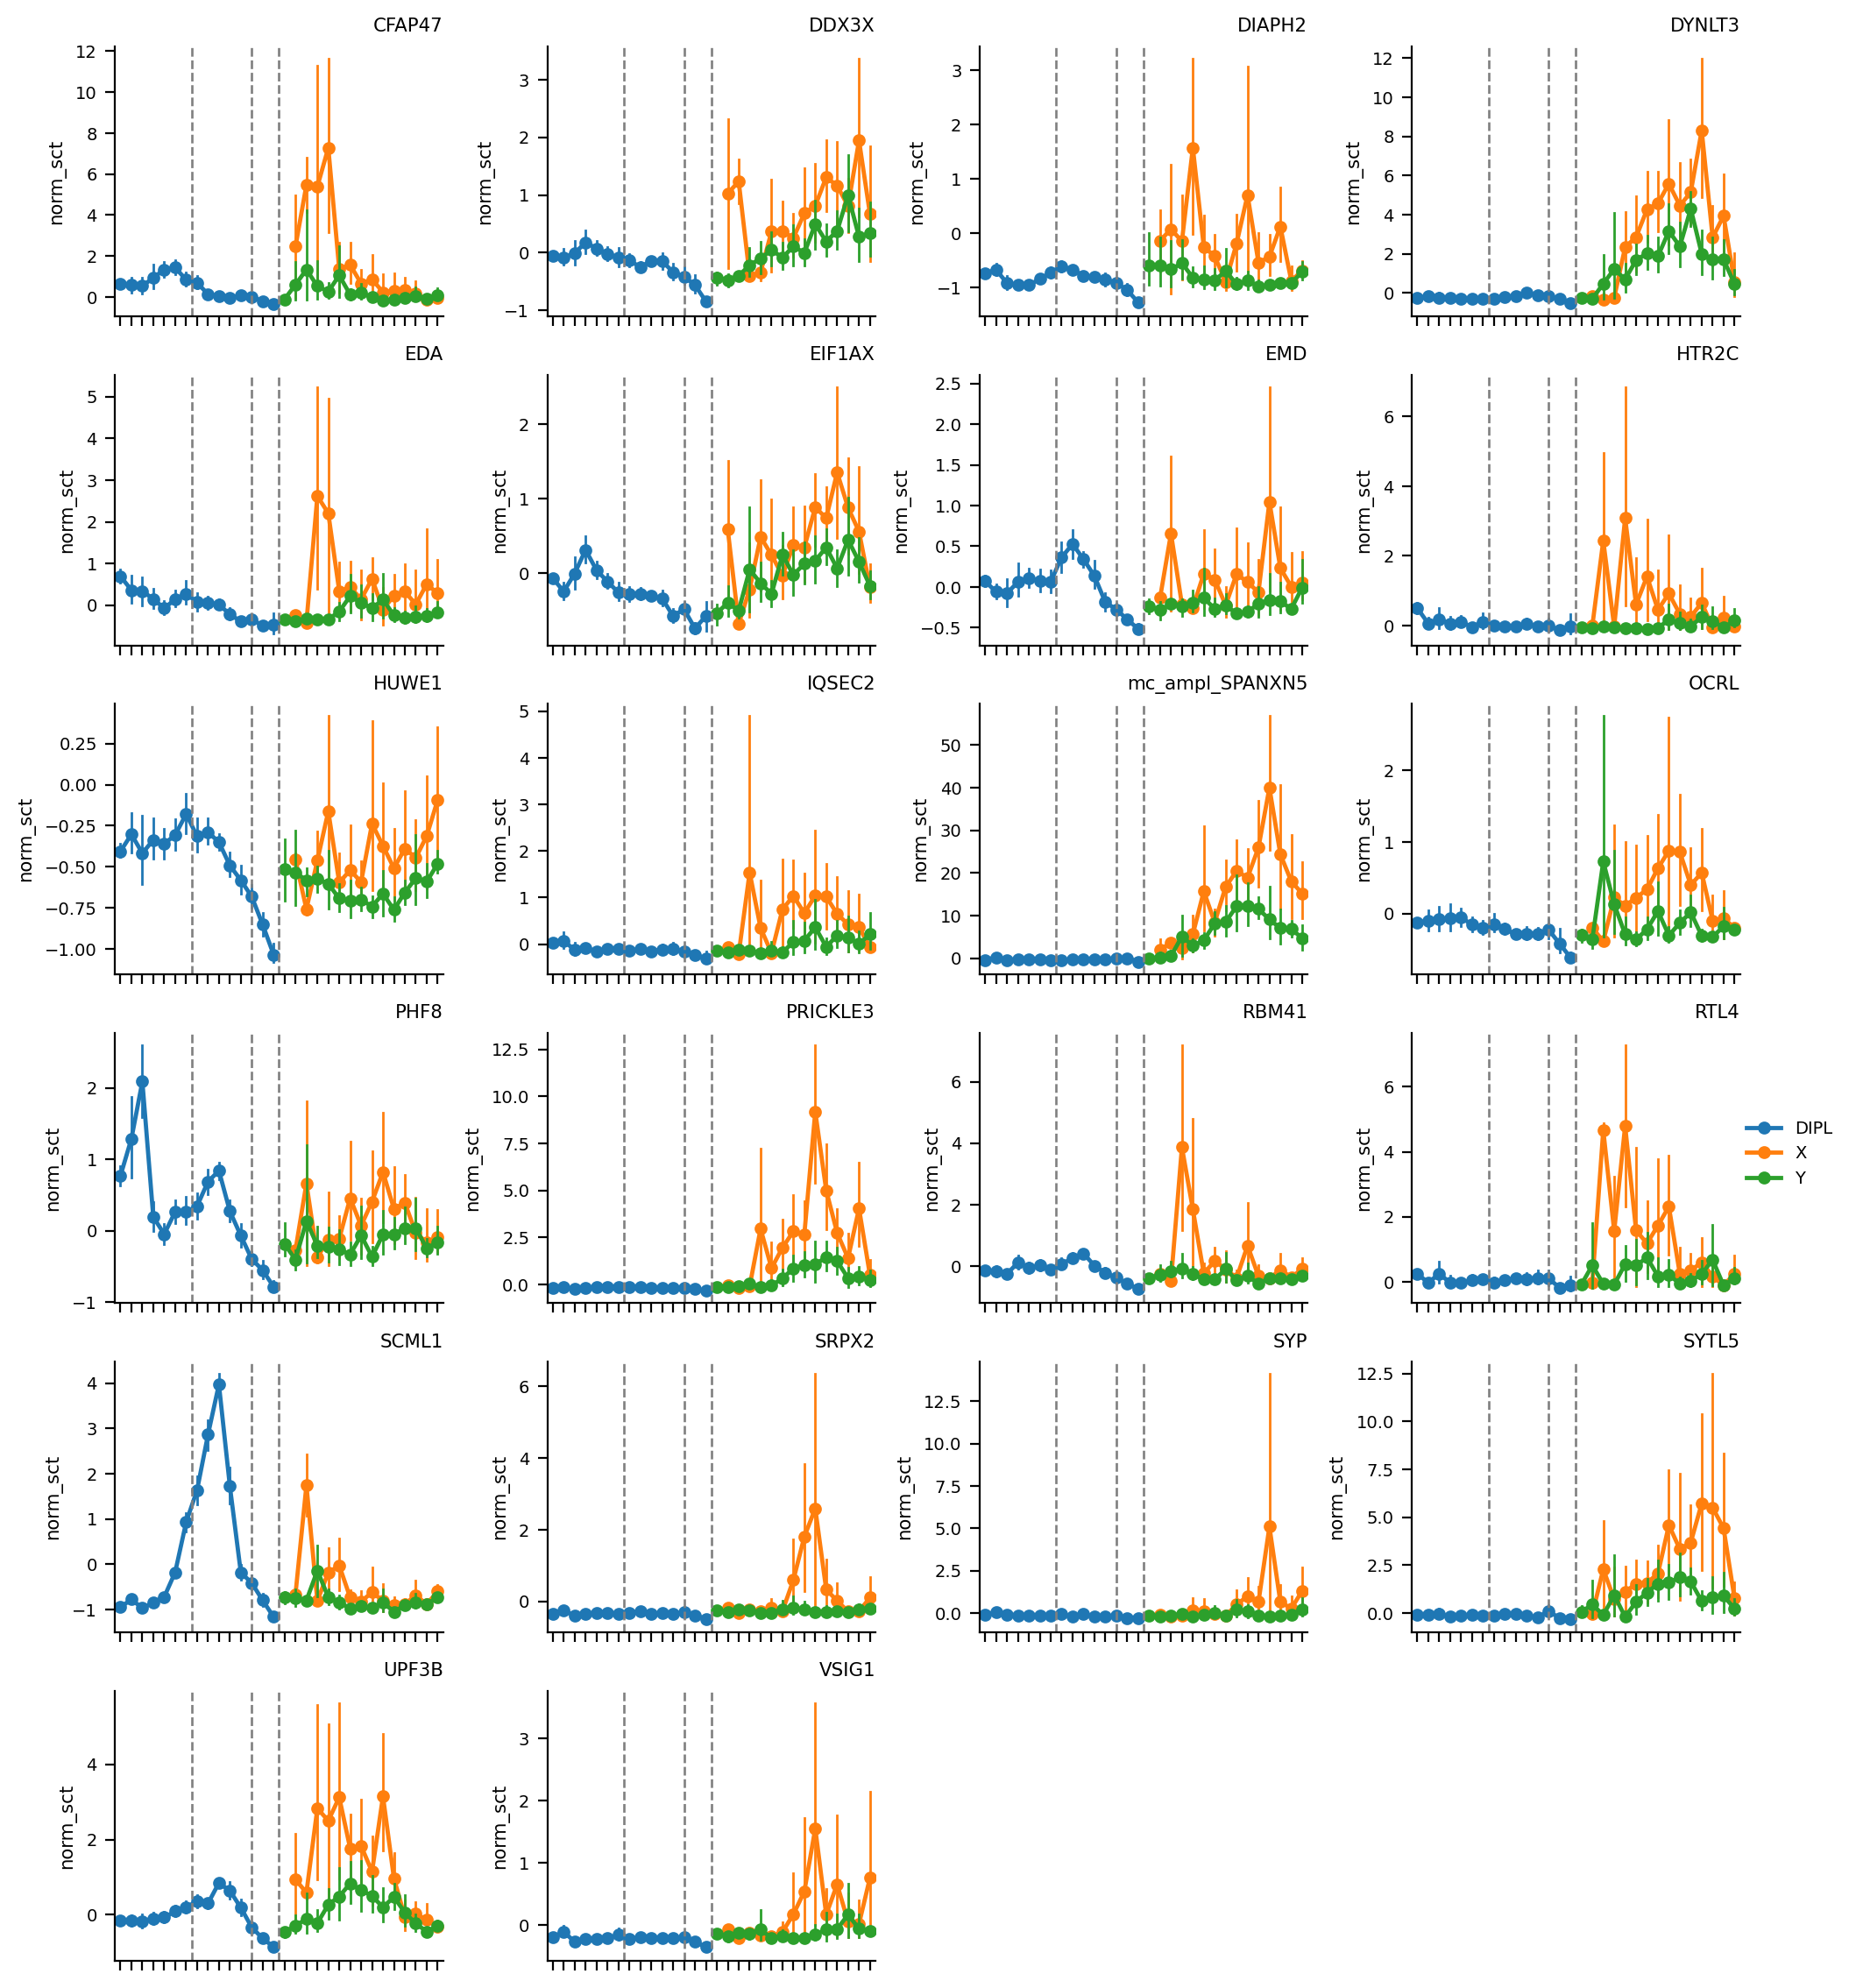

In [19]:
ep.facet_plot(sheet.get('cDEG'), ep.split_trajectory, 'norm_sct', sharey=False, errorbar=True, ncols=4)

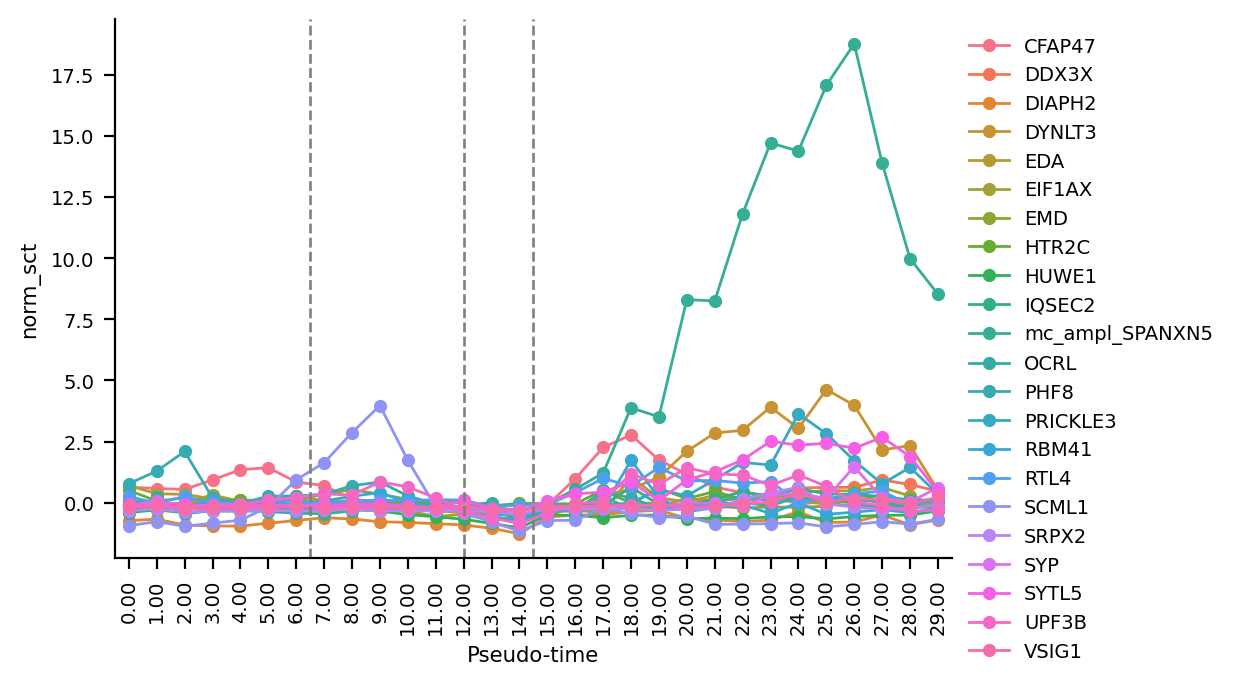

In [20]:
ep.trajectory(sheet.get('cDEG'), 'norm_sct') ;

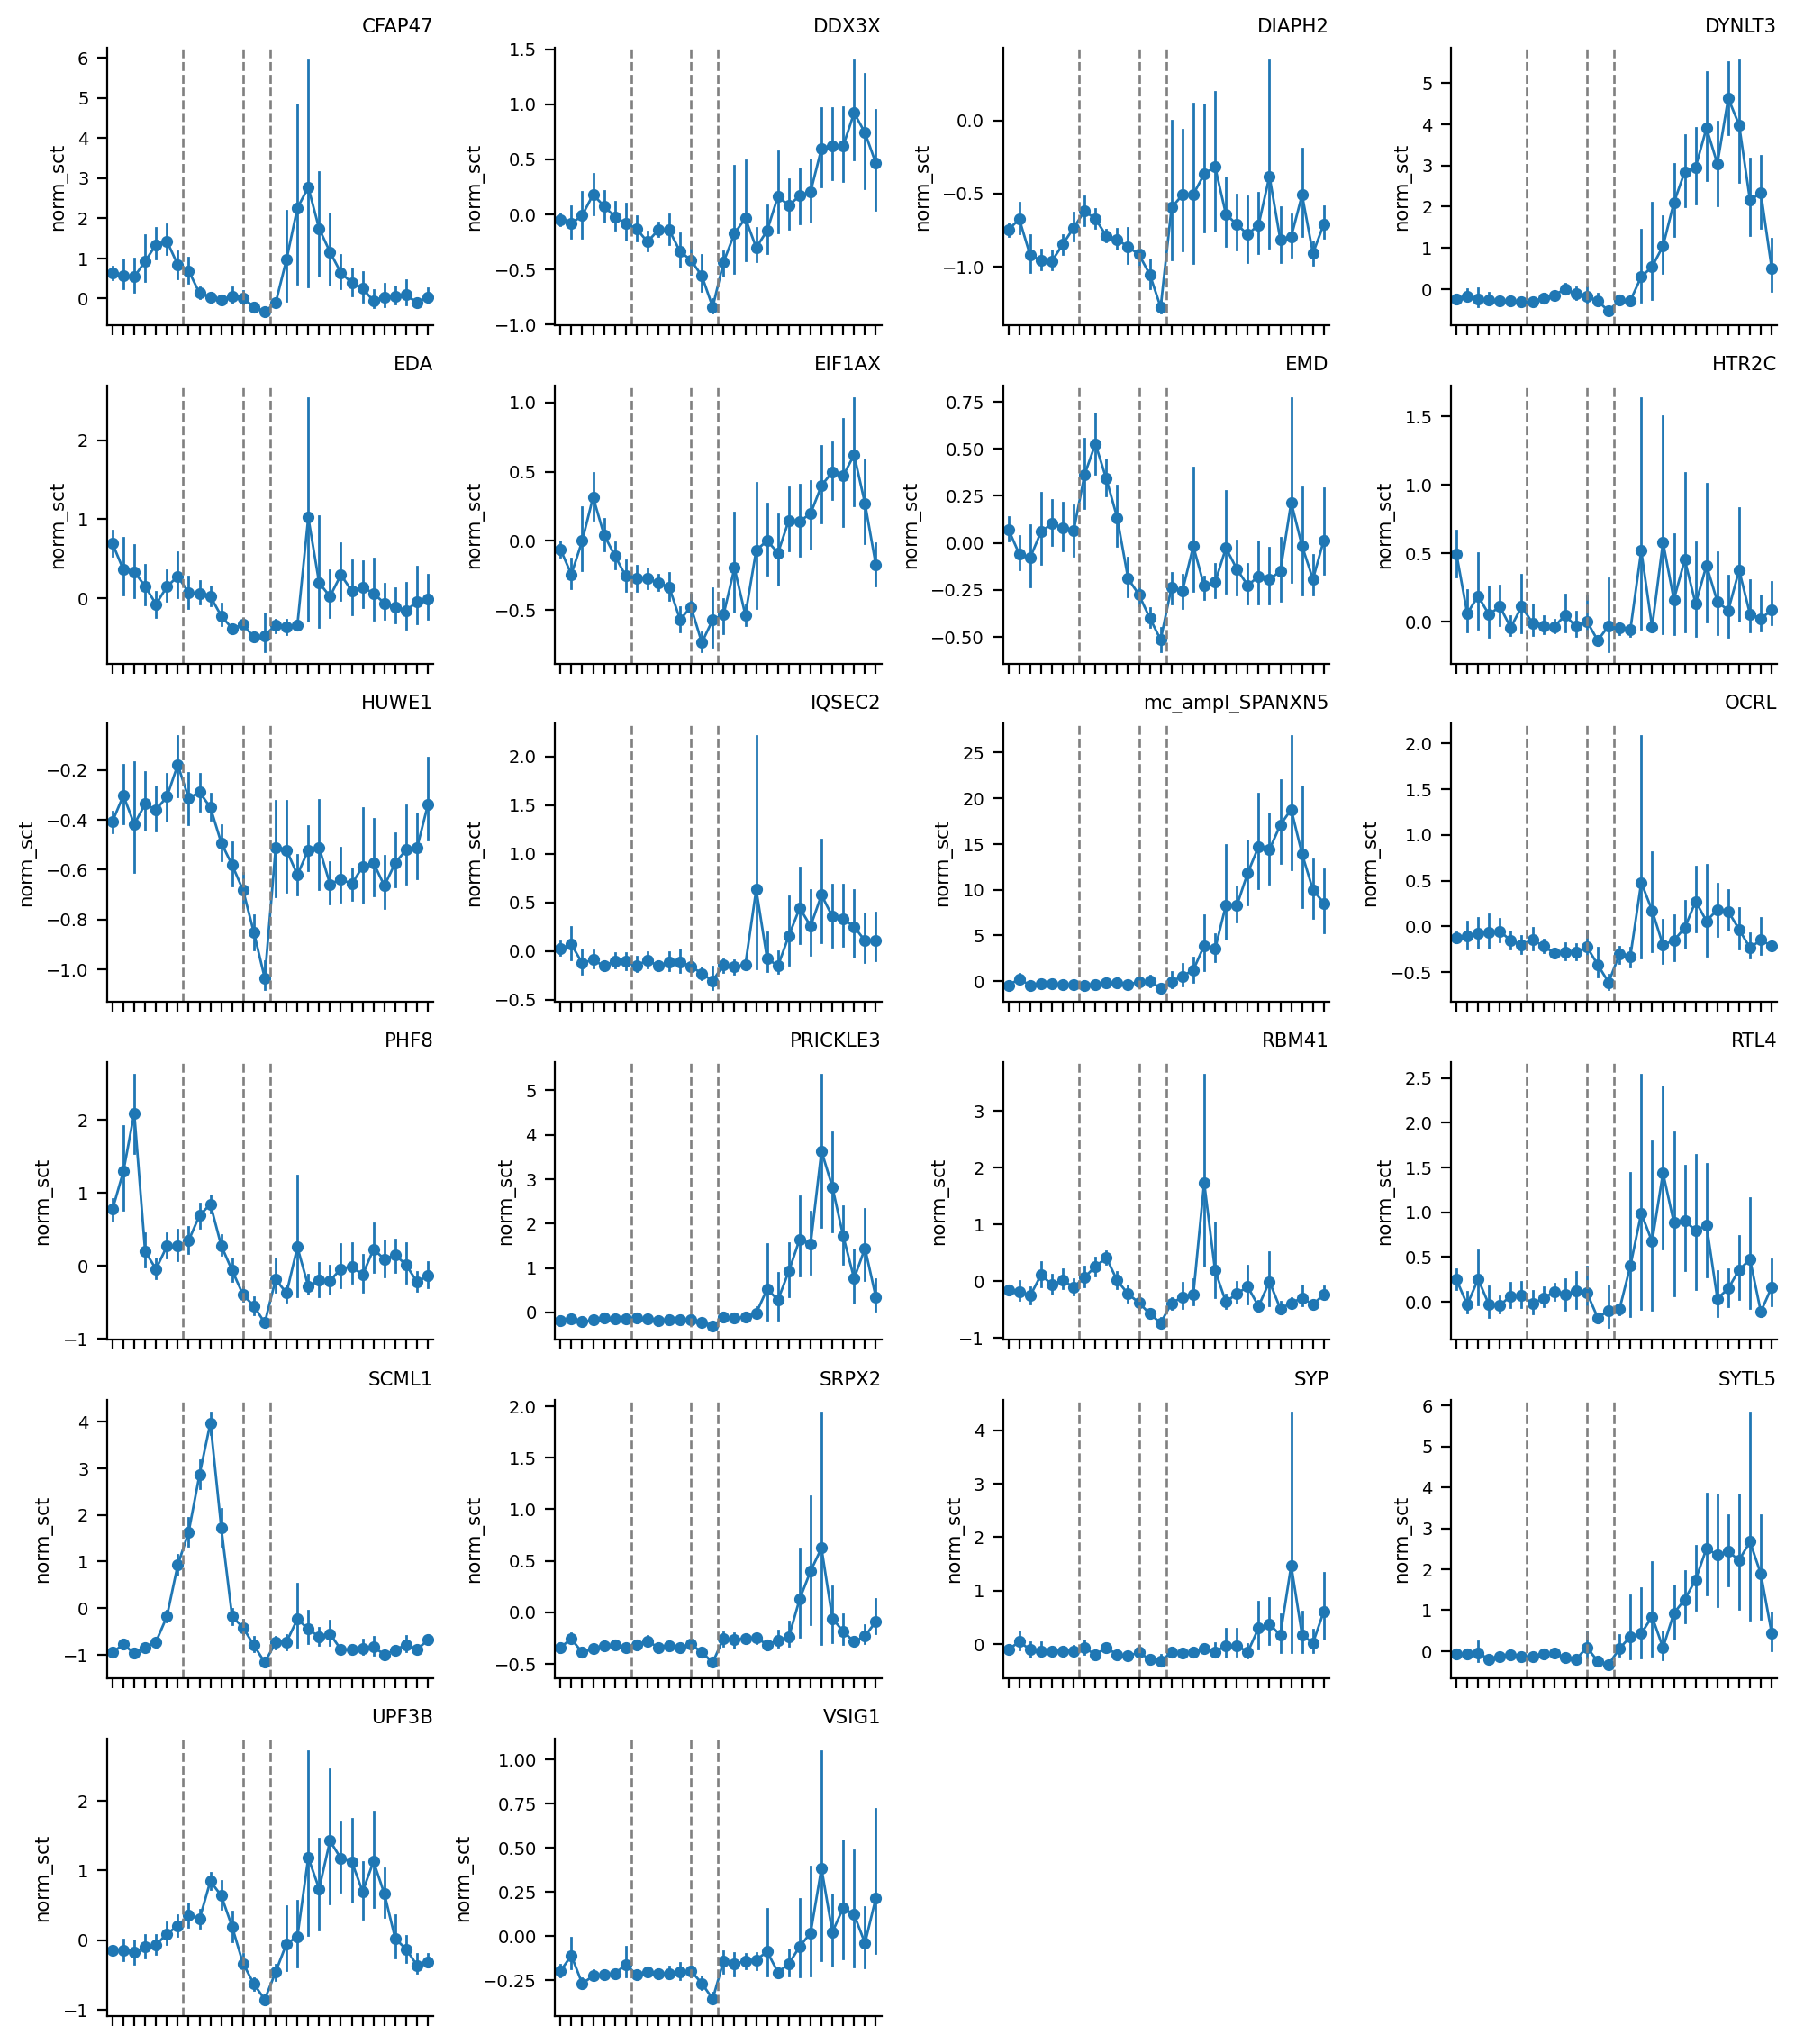

In [21]:
ep.facet_plot(sheet.get('cDEG'), ep.trajectory, 'norm_sct', sharey=False, errorbar=True, ncols=4)

In [22]:
# df = ep.adata[ep.adata.obs.SPECIES == "Human"].to_df(layer='norm_sct')
# df = ep.adata[(ep.adata.obs.SPECIES == "Human") & (ep.adata.obs.Pseudotime_scaled > 0.5)].to_df(layer='norm_sct')
df = ep.adata[ep.adata.obs.Pseudotime_scaled > 0.5].to_df(layer='norm_sct')
df['ptime'] = pd.cut(ep.adata.obs.Pseudotime_scaled, include_lowest=True, bins=30)
ptime_bins = df['ptime'].unique().sort_values()
ptime_bins = ptime_bins[~ptime_bins.isnull()]
means_fine_df_all = df.groupby('ptime').mean()
means_fine_df_all.columns.name = 'gene'
means_fine_df_all = means_fine_df_all.transpose()
means_fine_df_all = means_fine_df_all[ptime_bins]

# only chrX
means_fine_df = means_fine_df_all.loc[ep.adata.var.chromosome == 'X']
means_fine_df.head()

/var/folders/s6/srs8qkh52w1_h32d65z95tth0000gn/T/ipykernel_3741/639468700.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means_fine_df_all = df.groupby('ptime').mean()


ptime,"(0.5, 0.533]","(0.533, 0.566]","(0.566, 0.6]","(0.6, 0.633]","(0.633, 0.666]","(0.666, 0.699]","(0.699, 0.733]","(0.733, 0.766]","(0.766, 0.799]","(0.799, 0.833]","(0.833, 0.866]","(0.866, 0.899]","(0.899, 0.933]","(0.933, 0.966]","(0.966, 0.999]"
gene,,,,,,,,,,,,,,,
GYG2,-0.042098,-0.054876,-0.034658,-0.036454,-0.076823,-0.076040,-0.084007,0.019663,-0.017971,-0.088350,0.005949,-0.069784,-0.058722,-0.056151,-0.013729
MXRA5,-0.018554,-0.025011,-0.010371,-0.015871,-0.030468,0.295876,0.431500,0.300871,0.071361,-0.033366,-0.044535,-0.024393,-0.019173,-0.017819,-0.003941
PUDP,-0.117598,-0.302116,-0.277936,-0.273423,-0.254617,-0.365321,-0.340281,-0.360356,-0.375457,-0.388593,-0.416792,-0.338970,-0.320934,-0.240708,-0.136183
PNPLA4,-0.144925,-0.161147,-0.146323,-0.138263,-0.115004,-0.019218,-0.224271,-0.123541,-0.219987,-0.228769,-0.262250,-0.115995,-0.138356,-0.172467,-0.079661
ANOS1,-0.284120,0.045663,-0.281897,-0.277307,-0.363920,-0.367769,-0.295296,-0.389769,-0.310458,-0.390626,-0.418130,-0.353758,-0.323922,-0.271398,-0.101743


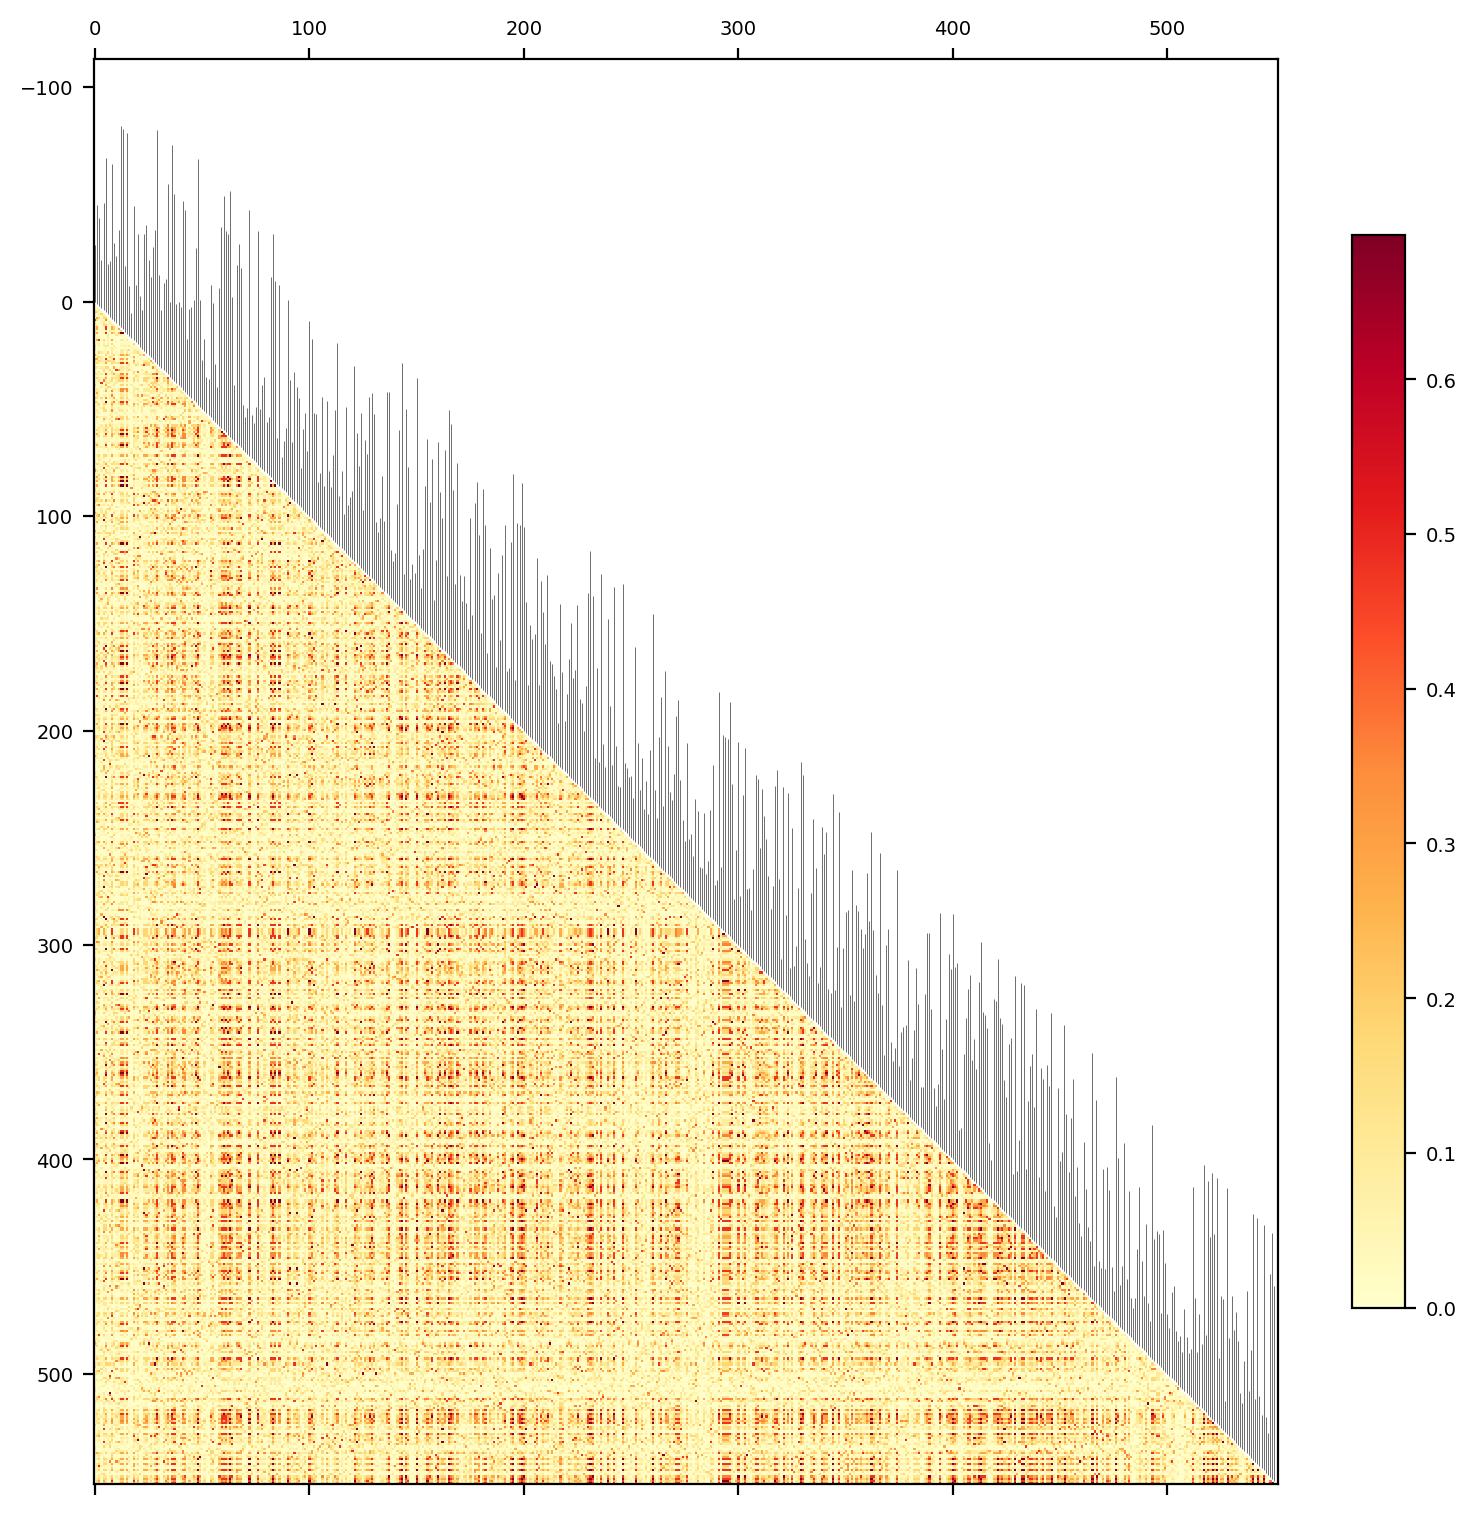

In [88]:
from bitarray import bitarray

def get_pairs(m, cutoff):
    m = m.copy()
    np.fill_diagonal(m, 0)
    dependent_windows = np.argwhere((m > cutoff))
    dependent_windows.sort()
    dependent_windows = np.unique(dependent_windows[dependent_windows[:, 0].argsort()], axis=0)
    return dependent_windows.tolist()

from math import log

def bitarray_mut_info(b1, b2):
    epsilon = 1e-12
    x11 = (b1 & b2).count(1) + epsilon 
    x10 = (b1 ^ b2 & b1).count(1) + epsilon 
    x01 = (b2 ^ b1 & b2).count(1) + epsilon 
    x00 = (b1 | b2).count(0) + epsilon 
    tot = x11 + x10 + x01 + x00
    x11 /= tot
    x10 /= tot
    x01 /= tot
    x00 /= tot
    x_1 = x11 + x01
    x1_ = x11 + x10
    x_0 = x00 + x10
    x0_ = x00 + x01
    mut_info = x11*log(x11/(x1_*x_1)) + x10*log(x10/(x1_*x_0)) + x01*log(x01/(x0_*x_1)) + x00*log(x00/(x0_*x_0))
    return mut_info


def compute_matrix(df, stat='proportion_paired'):

    matrix = df.values
    nr_windows = matrix.shape[0]
    window_size = 1
    np.array(np.meshgrid(range(nr_windows), range(nr_windows))) * window_size

    nr_indivs = 1

    columns = {}
    for i in range(matrix.shape[0]):
        columns[i] = bitarray(matrix[i].astype(int).tolist())
        
    index_array = np.array(np.meshgrid(range(nr_windows), range(nr_windows))) * window_size

    def mutual_information(args):
        i, j = args
        if i in columns and j in columns:
            return bitarray_mut_info(columns[i], columns[j])
        else:
            return np.nan    
        
    mean_admix_prop = matrix.mean()
        
    mi_m = np.apply_along_axis(mutual_information, 0, index_array)
    
    lst = []
    for _ in range(1000):
        b = bitarray(np.random.choice([0, 1], size=nr_windows, p=[1-mean_admix_prop, mean_admix_prop]).tolist())
        lst.append(bitarray_mut_info(b, ~b))
    perfect = sum(lst)/len(lst) # mut info for perfectly matching cols (assuming 0.5 admixture prop)
    
    # mi_m = mi_m / perfect
    # mi_m[mi_m > 1] = 1
    
    # interacting_windows = get_pairs(m, perfect * 0.8) 
    # return interacting_windows, m  
    
    # cutoff = 0.5
    cutoff = 0
    _m = mi_m.copy()
    np.fill_diagonal(_m, 0)
    pairs = np.argwhere((_m > cutoff)) #.tolist()
    values = _m[_m > cutoff] #.tolist()

    return pairs, values, mi_m            



df = (((np.sign(means_fine_df.T - means_fine_df.T.shift()) + 1) / 2).iloc[1:]).T
# df = ((np.sign(means_fine_df.T - means_fine_df.T.shift()) + 1) / 2).iloc[1:]

mi_interacting_windows, mi_values, mi_m = compute_matrix(df, stat='mut_info')

def transform(m):
    btw_0_1 = (m - m.min()) / m.max()
    return 1-np.log1p(1-btw_0_1)

# mat = transform(mi_m)
mat = mi_m.copy()

mat[np.triu_indices(mat.shape[0], -1)] = np.nan

# HACK:
mat[np.isinf(mat)] = np.nan



fig, ax = plt.subplots(1, 1, figsize=(8, 8))
g = ax.matshow(mat, 
               # cmap='viridis',
               cmap=matplotlib.cm.YlOrRd,
               # vmin=0, vmax=1,
              )
cb = fig.colorbar(g, location='right', ax=ax, shrink=0.7)

# # to get alphas to be 0-1 with a cutoff of 0.50
# mi_values = (mi_values-0.5) * 2

interval = (190, 210)
s, e = interval
for (a, b), v in zip(mi_interacting_windows, mi_values):
    
    if a > b:
        continue

    if v < 0.99:
        continue
    
    # if not (s <= a < e or s <= b < e):
    #     continue
        
    ax.hlines(a, a, b, color='black', linewidth=0.05, 
              alpha=v,
             )
    ax.vlines(b, b, a, color='black', linewidth=0.05, 
              alpha=v,
             )

colsums = np.nansum(mi_m, axis=1)
lengths = colsums#**2/100
plt.vlines(np.arange(colsums.size), 
            np.arange(colsums.size)-lengths,
            np.arange(colsums.size),
            color='black',
            linewidth=0.2,
)
#plt.gca().invert_yaxis()

plt.tight_layout()


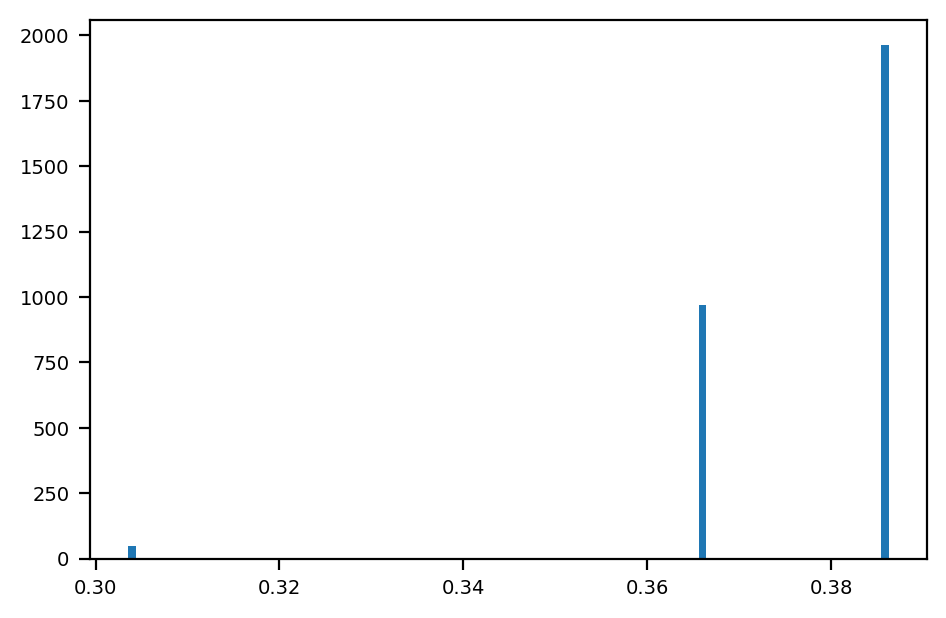

In [38]:
plt.hist(mi_values, bins=100) ;

/Users/kmt/cDEGexploration/.pixi/envs/default/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/kmt/cDEGexploration/.pixi/envs/default/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


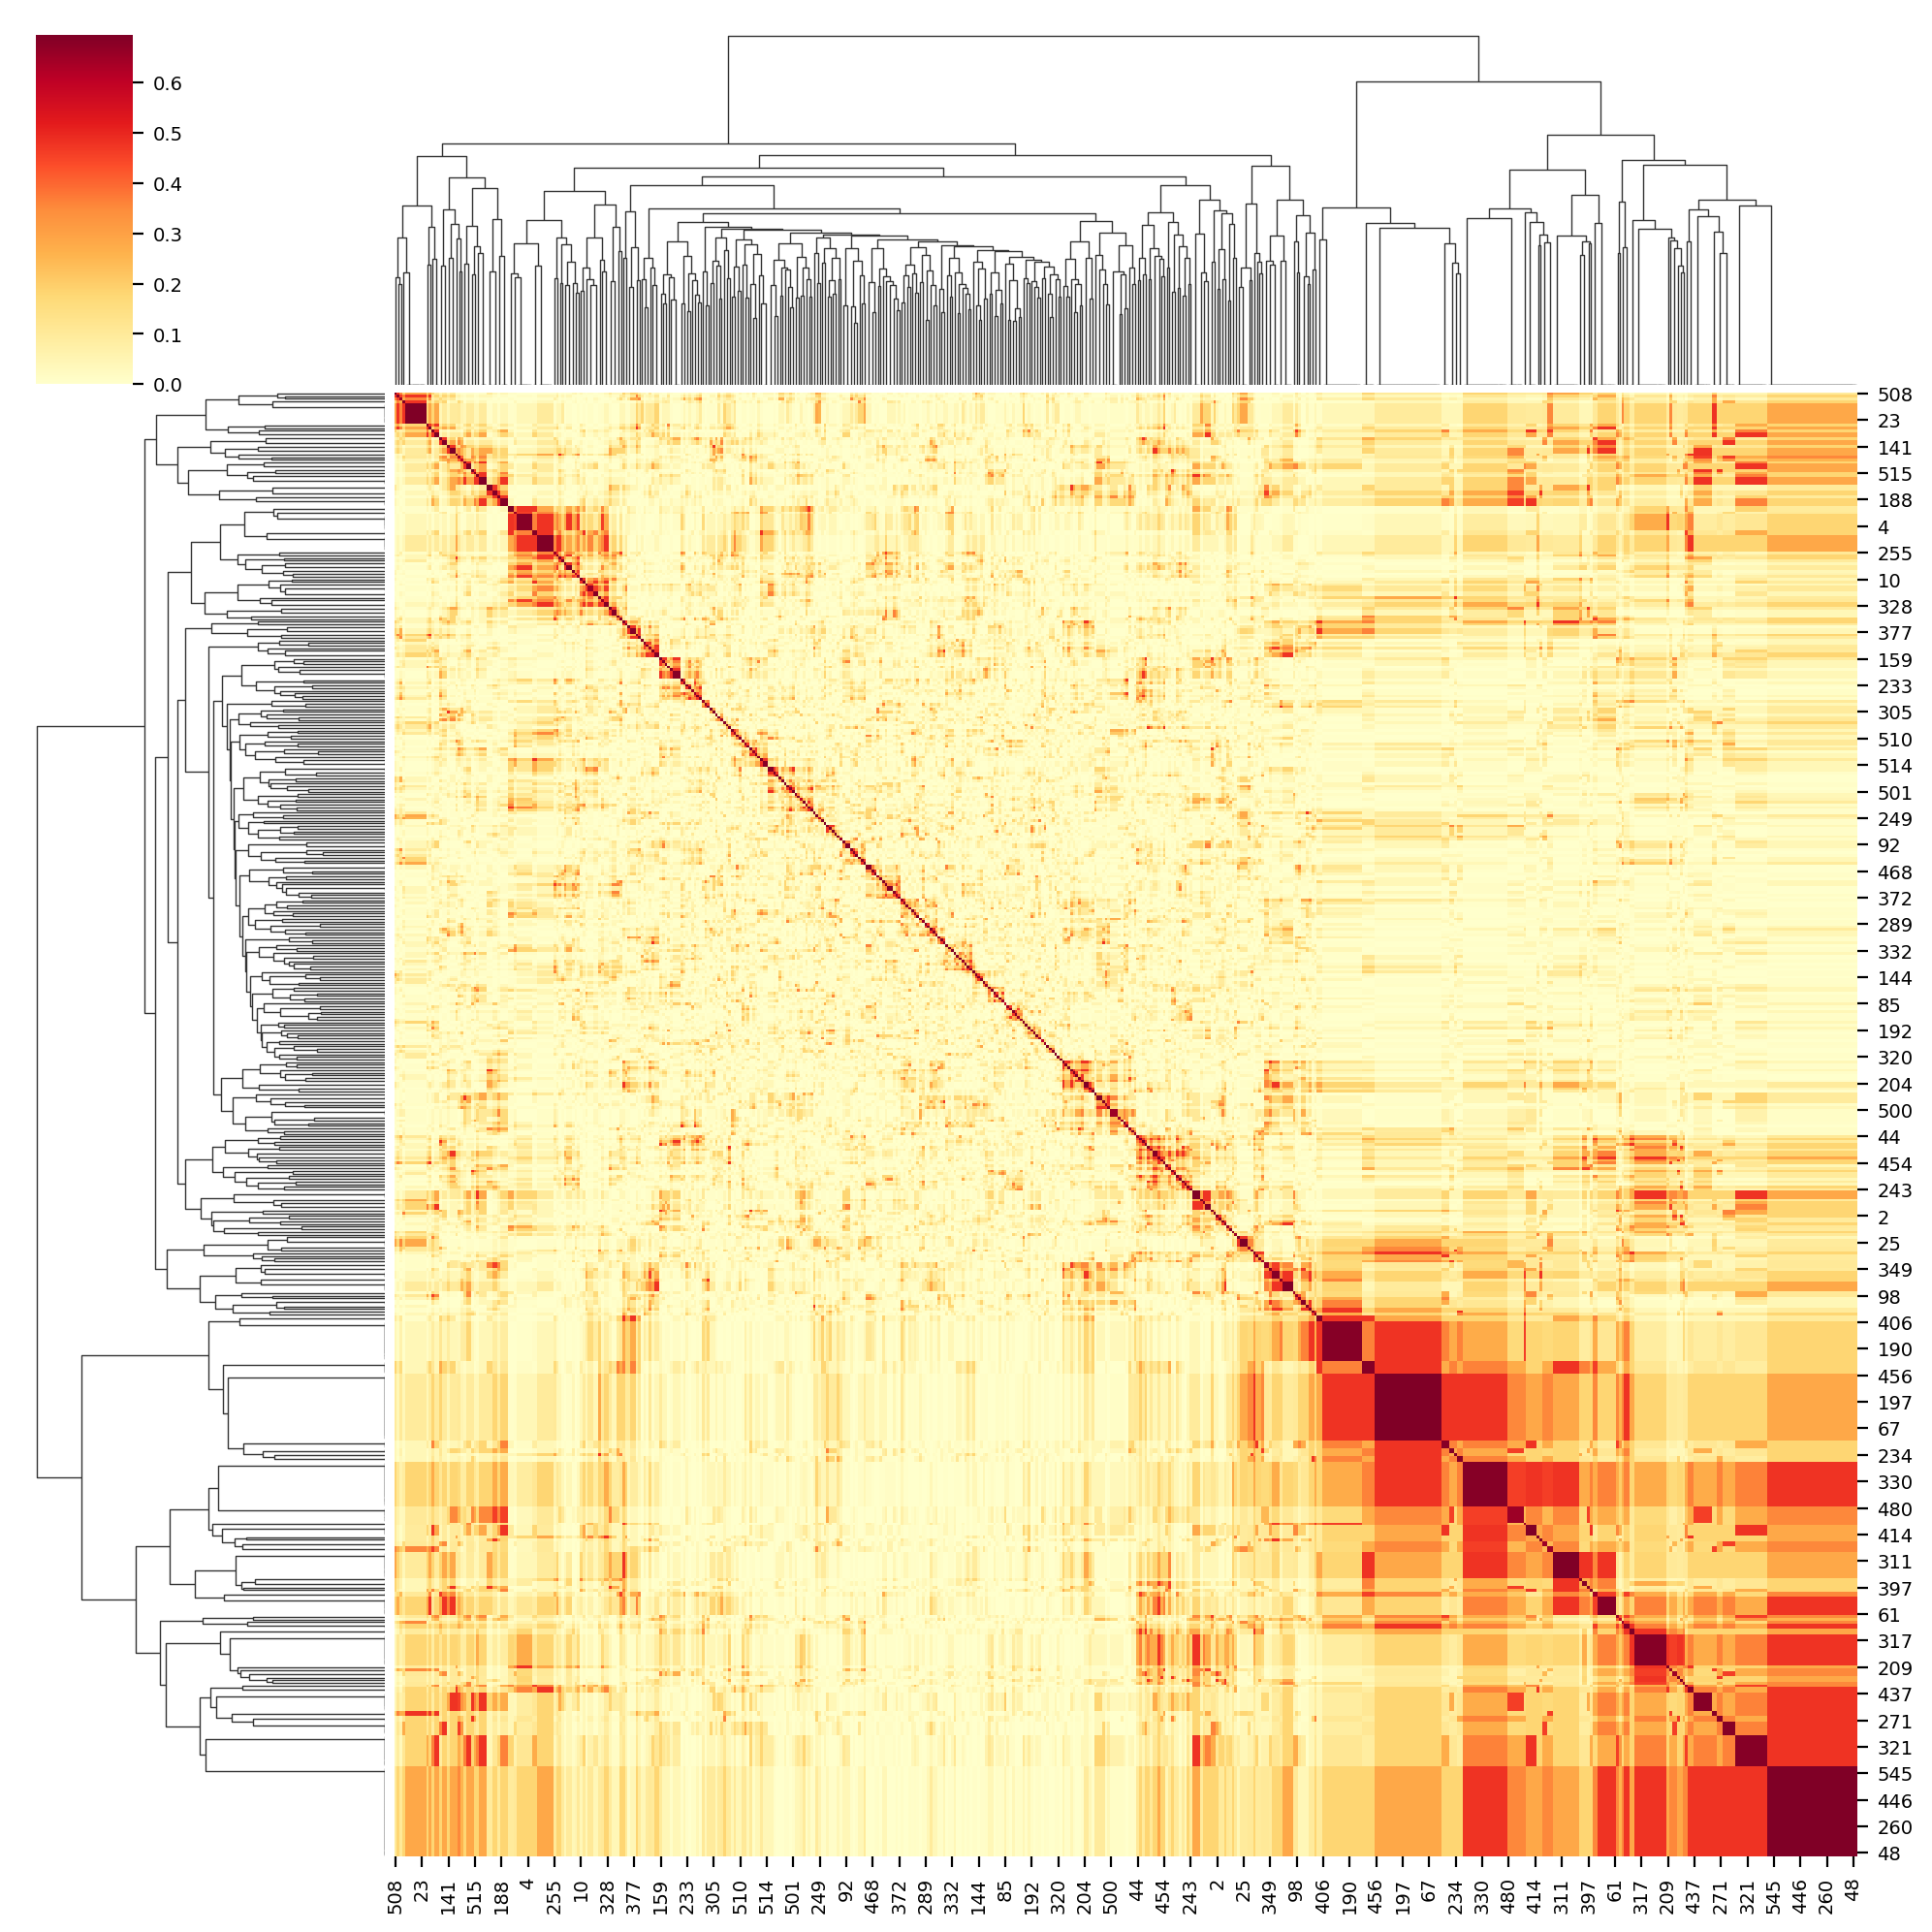

In [91]:
sns.clustermap(mi_m, cmap=matplotlib.cm.YlOrRd)

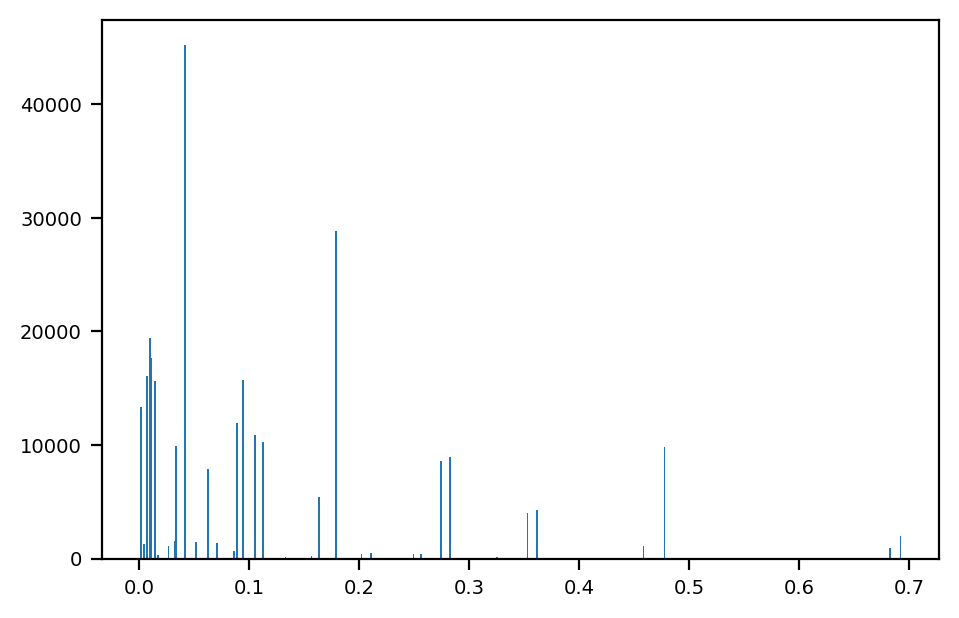

In [ ]:
plt.hist(mi_values, bins=500) ;

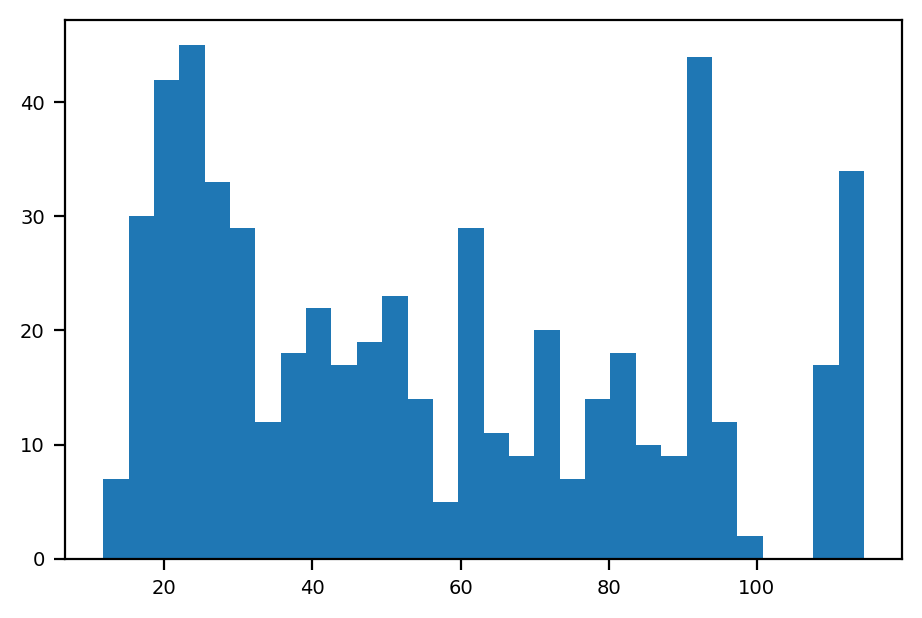

In [66]:
plt.hist(np.nansum(mi_m, axis=1), bins=30) ;

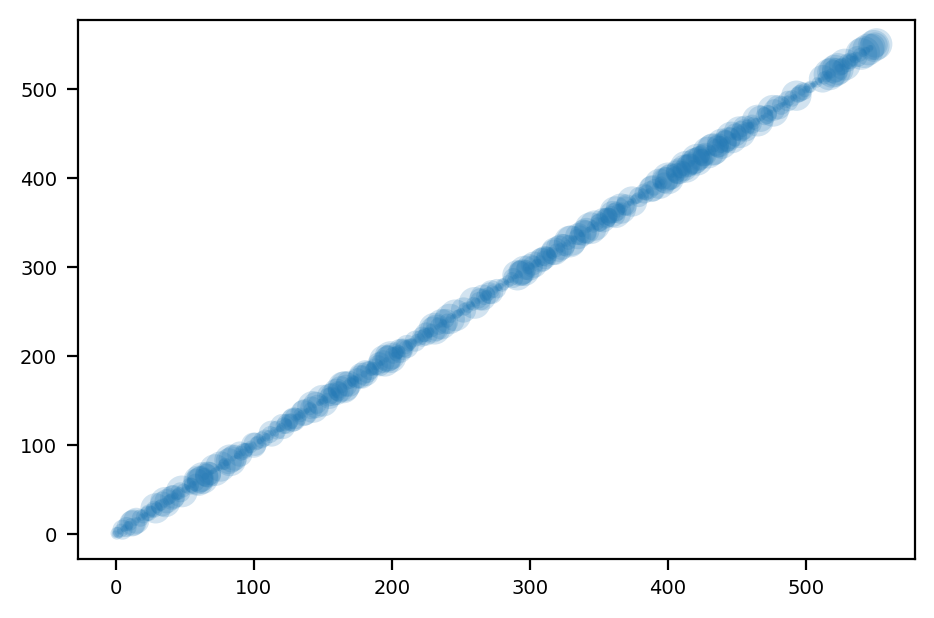

In [74]:
colsums = np.nansum(mi_m, axis=1)
plt.scatter(np.arange(colsums.size), np.arange(colsums.size), 
            s=colsums**2/100, 
            alpha=0.2,
           edgecolor='none')

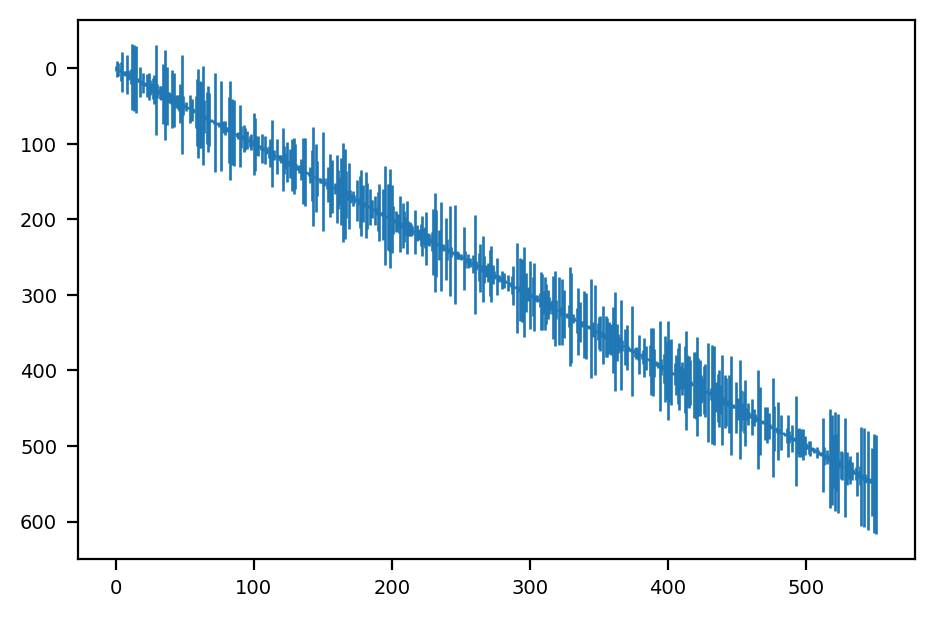

In [77]:
colsums = np.nansum(mi_m, axis=1)
lengths = colsums**2/100
plt.vlines(np.arange(colsums.size), 
            np.arange(colsums.size)-lengths/2, 
            np.arange(colsums.size)+lengths/2,
)
plt.gca().invert_yaxis()